In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import shap
import sklearn.metrics as metrics


Read expression data matrix and ground truth, and fix global data variables


In [11]:
data_file = f"data/5_mr_50_cond/simulated_noNoise.txt"  #5 or 40 or 100

data = pd.read_csv(data_file, sep="\t", header=0)

N_genes = 100  # total no. of genes
N_TFs = N_genes

Fix hyperparameters

In [12]:
n_estimators=1000  # number of trees in the forest (as per GENIE paper)
criterion='squared_error'  # variance reduction equivalent
max_features = np.sqrt(N_genes-1) # max no. of features to use in each tree (as per GENIE paper)
random_state = 42  # for reproducibility


Fit models per gene

In [13]:
# Normalize Expression data to unit-variance
data_n = StandardScaler(with_mean=False).fit_transform(data.to_numpy())

# Initialize matrices
W = np.zeros(shape=(N_genes,N_TFs))
Fscores = np.zeros(shape=(N_genes,))

for j in np.arange(0,N_genes):
    # read TF and gene expression data X and Gj
    X, Gj= data_n[:,:100], data_n[:,N_genes+j]

    # NOTE: Do we want/need to reserve some genes for validation?
    #       GENIE3 uses all but the current target gene's expression data
    #       while whe are only using the TFs.

    # fit an RF model to predict gene expression from TF
    M_rf = RandomForestRegressor(criterion=criterion, n_estimators=n_estimators, max_features=max_features, random_state=random_state).fit(X,Gj)

    # train score
    Fscores[j] = M_rf.score(X,Gj)

    # Get the weights for all edges connecting TFs to gene j
    W[j,:] = M_rf.feature_importances_

        # # # look at feature importance based on SHAP values
    # # explainer = shap.TreeExplainer(M_rf)
    # # shap_values = explainer(X)



Visualize importance scores for all genes

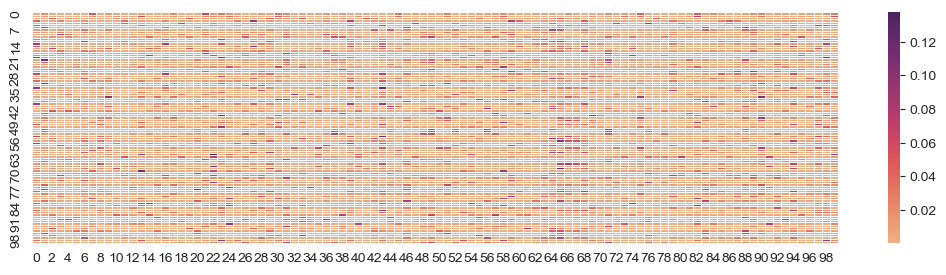

In [62]:
plt.figure(figsize=(13, 3))
ax = sns.heatmap(pd.DataFrame(np.abs(W)),
            cmap = "flare",
            linewidths=0.5)


Aggregate Gene-specific rankings and visualize

In [51]:
W_df = pd.melt(pd.DataFrame(np.abs(W)), var_name='TF_ID', value_name='Imp')

In [59]:
W_df_agg = W_df.groupby("TF_ID", sort=False, as_index=False).agg(['mean', 'std'])['Imp'].reset_index()
W_df_agg = W_df_agg.sort_values(by='mean', ascending= False)

W_df_agg

,index,mean,std
65,65,0.021008,0.024386
43,43,0.018561,0.025826
23,23,0.015654,0.022757
0,0,0.015556,0.021789
68,68,0.015314,0.018199
...,...,...,...
77,77,0.005901,0.006972
10,10,0.005783,0.008726
34,34,0.005776,0.009560
5,5,0.005743,0.007035




The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.



The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.



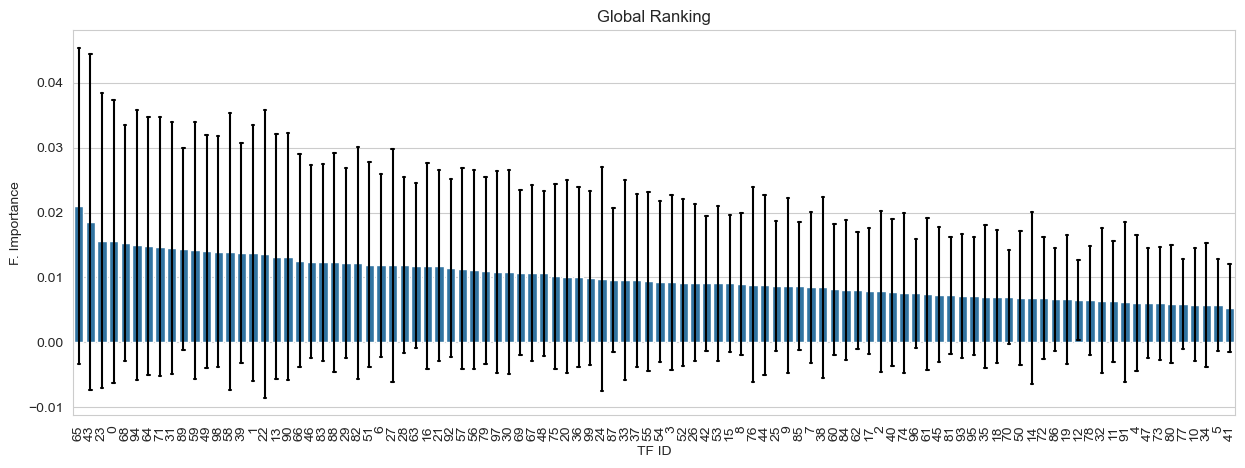

In [63]:

# Set the figure size
plt.figure(figsize=(15,5))

# plot a bar chart
ax = sns.barplot(x="TF_ID", y="Imp",
                 data=W_df, errorbar='sd',
                 order=W_df_agg.index,
                 capsize=.2, errwidth=1.5,
                 errcolor="black")
ax.set_xlabel('TF ID')
ax.set_ylabel('F. Importance')
ax.set_title("Global Ranking")
ax.tick_params(axis = 'x',labelrotation=90)

In [15]:

    # # wj.nlargest(20).plot(kind = 'barh')
    #
    # #
    # # # plot
    # # shap.summary_plot(shap_values, X)
    # pass





IndentationError: unexpected indent (171831894.py, line 10)